In [2]:
import ROOT

Welcome to JupyROOT 6.22/02


Vi har eget möte tisdag 3 november kl 09:15.

Vad är stråldos för någonting? (enhet)

Vi vill göra klart för oss vilken data vi har tillgång till och vad som är känt om fördelningarna.
hur ofta får man en puls från vardera fördelning, brus, signal.

kan vi använda det större fönstret tillsammans med det lilla för att bestämma "event_ratio"?

fungerar sensorn en samplingsmetod? AKA samplar den signalen vid diskreta tidpunkter.

kan samma sensor räkna flera partiklar under det lilla tidsfönstret

förmodligen inte superintressant, två partiklar som kommer efter varandra innom mycket kort tid, vad händer då?

<br><br><br><br><br>


Sensorn kan inte detektera om flera partiklar åker igenom efter vrandra under det lilla tidsfönstret.

Vi vill ta reda på hut väl vi kan bestämma bruset.

stråldos, neutron equivalent sensorn ska klara 10^15 neutroner vilket blir efter några år. är per ytenhet.

Vi kan anta att vi vet hur fördelningen av signalen ser ut. Bruset ser sut som det gör och ändras inte med strålning.

https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/UPGRADE/CERN-LHCC-2020-007/fig_014a.png

olika delar av samma modul kommer att utsättas för olika stråldos.


Jag vill studera hur fel värden man får om man inte vet det normalfördelade brusets standardavvilkelse ordentligt. Man skulle för övrigt kunna anta att vi inte vet mu eller sigma för landaufördelningen för signalen heller.

Vet vi mu och sigma exakt för signalen så kan vi helt enkelt sätta ett högt tröskelvärde för att få med försummbart lite brus och sedan använda kunskap om distributionen för att beräkna det faktiska antalet träffar. Likaså om vi vet brusets standardavvikelse exakt kan vi sätta tröskelvärdet lågt för att detektera nästan alla riktiga träffar och använda kunskapen om bruset för att räkna ut antalet faktiska träffar.

Kör vi en kort tid kommer denna metod inte fungera särskilt bra eftersom slumpen spelar en större roll som vår kunskap om den teoretiska fördelningen inte kan kompensera för.

Givetvis kan vi inte veta varken det ena eller det andra exakt och därför ger rimligtvis ett tröskelvärde som är en mellangrund till dessa extremer bäst noggrannhet.

Som jag har förstått det kan vi använda det större tidsfönstret för att bestämma standardavvikelsen hos bruset, stämmer detta? Isåfall, hur går det till och hur noga kan vi göra det?

Tillåter sensorn att mäta energinivåerna på signalen eller kan vi bara säga om det är över eller under vårt tröskelvärde? Vi mäter bara träff eller inte, antal i stora och antal i lila fönstret.

Poissionförddelning av antalet kollisioner per bunch crosssing. Okej kan vi utnyttja detta på något sätt?

I projektintroduktionen/beskrivningen står att S/B förväntas sjunka från 20 då sensorerna är nya till omkring 4 då sensorerna har blivit slitna, och Ohm sa att detta främst sker genom att signalstyrkan minskar och inte att bruset ökar.

Här räknar vi ut exakta fördelningarna

0.9999999998229326 3.1671241833119924e-05


Warning in <TCanvas::Constructor>: Deleting canvas with same name: I dont even know where this will show up


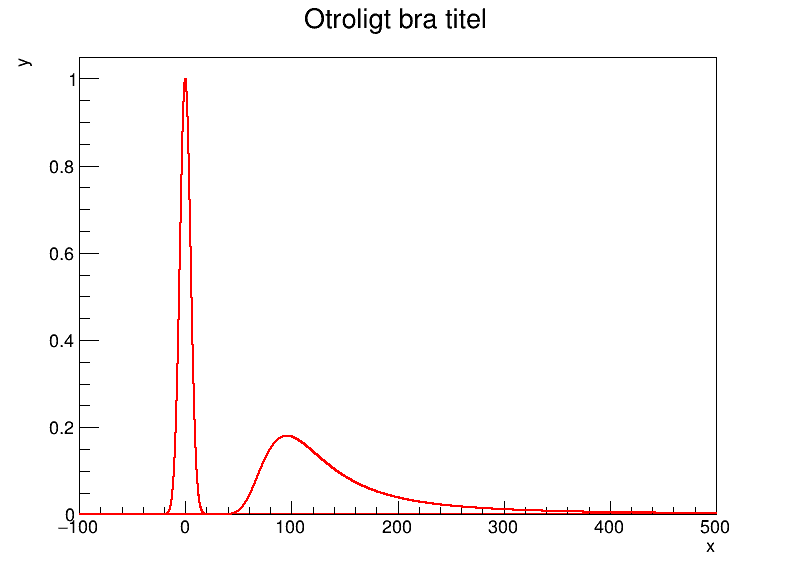

In [6]:
noise_sigma = 5 # mV
signal_mu = 100 # mV
signal_sigma = 20 # mV

fNoise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, 0, %f)" % noise_sigma, -100, 500)
fNoise.SetNpx(10000)
fSignal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (signal_mu, signal_sigma), -100, 500)
fSignal.SetNpx(10000)

canvas = ROOT.TCanvas("I dont even know where this will show up", "not this either", 800, 600)

fNoise.Draw()
fNoise.GetHistogram().GetXaxis().SetTitle("x")
fNoise.GetHistogram().GetYaxis().SetTitle("y")
fNoise.SetTitle("Otroligt bra titel")


fSignal.Draw("SAME")
fSignal.GetHistogram().GetXaxis().SetTitle("x")
fSignal.GetHistogram().GetYaxis().SetTitle("y")
fSignal.SetTitle("En titel")

threshold = 20

all_signal = fSignal.Integral(-100, 500)
all_noise = fNoise.Integral(-100, 500)

threshold_signal = fSignal.Integral(threshold, 500)
threshold_noise = fNoise.Integral(threshold, 500)

expected_signal_above = threshold_signal/all_signal
expected_noise_above = threshold_noise/all_noise

print(expected_signal_above, expected_noise_above)

canvas.Draw()

Tanken är här att simulera det ovan och använda de kända intervallen för att kompensera och se hur bra anpassning vi får.

1.0000000001770675 1.2629754213859197


Warning in <TROOT::Append>: Replacing existing TH1: randomnumbers (Potential memory leak).


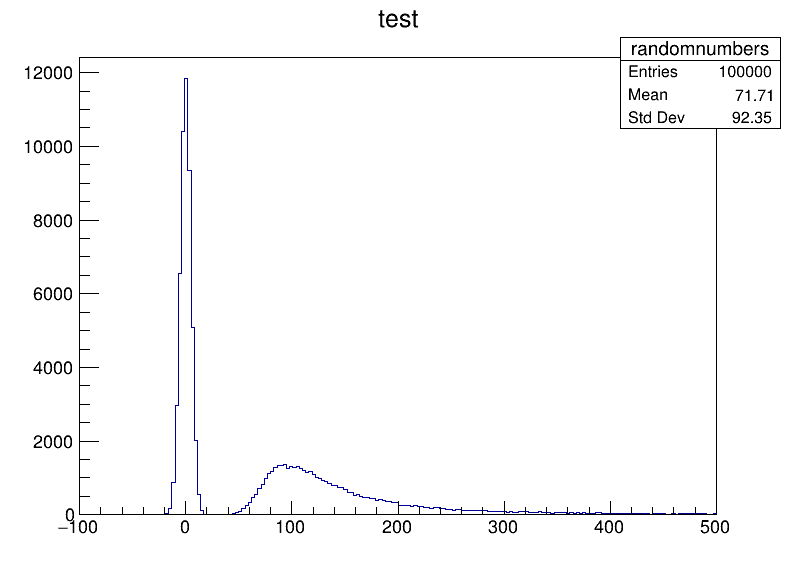

In [7]:
hist = ROOT.TH1F("randomnumbers", "test", 200, -100, 500)
prng = ROOT.TRandom3(123)

event_count = 100000
event_ratio = 0.5 # relevant fråga: vad räknas som en störning?
signal_count = int(round(event_count * event_ratio))
noise_count = event_count - signal_count

noise_above_count = 0
signal_above_count = 0

for i in range(signal_count):
    signal = prng.Landau(signal_mu, signal_sigma)
    hist.Fill(signal)
    if signal > threshold:
        signal_above_count += 1

for i in range(noise_count):
    noise = prng.Gaus(0, noise_sigma)
    hist.Fill(noise)
    if noise > threshold:
        noise_above_count += 1


# Här vill jag räkna antalet
print((signal_above_count/expected_signal_above)/signal_count, (noise_above_count/expected_noise_above)/noise_count)

hist.Draw()
canvas.Draw()

Fråga, kan vi bestämma parametern för landaufördelningen på något sätt eller är det en ren gissning. Kan sensorn ge ut spänningen eller ger den bara ut om det är över eller under vår gräns. Får man ut spänningen kan man anpassa kurvan och uppskatta fördelningen.

Vi vill verkligen veta precis vilken data vi har tillgång till så att vi ved hur lösningen ska optimeras.


känner vi till förhållande i antal mellan signal och brus?


Varje cell har en viss sannolikhet att gå över tröskeln, ska multipliceras med totala antalet kanaler.

Mäter i luminousitet block om en minut